In [ ]:
# STEP 1: Install required Qiskit packages
!pip install "qiskit<1.0" --upgrade --quiet
!pip install qiskit-aer==0.12.0 --quiet  # avoid 0.13.x due to 'Store' issue
!pip install pylatexenc --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# STEP 2: Imports (no Aqua or deprecated opflow)
import qiskit
print("Qiskit version:", qiskit.__version__)

Qiskit version: 0.46.3


In [ ]:
import numpy as np
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA
from qiskit_aer import Aer
from qiskit.primitives import Estimator

<ipython-input-3-559f6eb214d2>:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.minimum_eigensolvers import VQE


In [ ]:
num_qubits = 4   # number of grid points

E = [1.0,1.0,1.0,1.0]    # list of KE coefficients for each grid points

J = [
    [0.0 , 0.5 , 0.3 , 0.2] , # Coupling strengths between points ( modelling vorticity interactions between points i and j)
    [0.5 , 0.0 , 0.4 , 0.1] ,
    [0.3 , 0.4 , 0.0 , 0.3] ,
    [0.2 , 0.1 , 0.3 , 0.0]
]
# The above corresponds to the interaction Hamiltonian : H_interaction
# J[i][i] : diagonal elements are 0 --> no self interaction
# J_ij = J_ji as interactions are mutual

In [ ]:
def time_dependent_J(t) :
  return np.array(J)*np.exp(-0.1 *t)    # decaying vorticity.

# E[i] remain constant over time, only coupling terms evolve with time


In [ ]:
# Fix qubit 0 to represent a wall
boundary_qubit = 0
E[boundary_qubit] = 0.0         # No kinetic energy at the boundary i.e for qubit 0

for i in range(num_qubits):
  J[boundary_qubit][i] = 0.0    # Removes interaction between
  J[i][boundary_qubit] = 0.0    # wall qubit and rest of the grid

# No X_0X_j or Y_0Y_j terms --> qubit 0 is disconnected from system, it does not
# move or affect other qubits


In [ ]:
from qiskit.opflow import PauliSumOp

pauli_list_raw = []

for i in range(num_qubits):
    z_label = "I" * i + "Z" + "I" * (num_qubits - i - 1)
    pauli_list_raw.append((z_label, E[i]))

    for j in range(i + 1, num_qubits):
        xx_label = "I" * i + "X" + "I" * (j - i - 1) + "X" + "I" * (num_qubits - j - 1)
        yy_label = "I" * i + "Y" + "I" * (j - i - 1) + "Y" + "I" * (num_qubits - j - 1)

        pauli_list_raw.append((xx_label, J[i][j]))
        pauli_list_raw.append((yy_label, J[i][j]))

# Now construct the PauliSumOp
hamiltonian = PauliSumOp.from_list(pauli_list_raw)


In [ ]:
ansatz = TwoLocal ( num_qubits , 'ry' ,  'cz' , reps =2 , entanglement = 'full' )


In [ ]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
import matplotlib.pyplot as plt

# Assuming num_qubits is already defined
num_qubits = 4  # Replace with your actual value

# Create the TwoLocal ansatz
ansatz = TwoLocal(num_qubits, 'ry', 'cz', reps=1, entanglement='full')

# Convert the ansatz to a QuantumCircuit object
circuit = ansatz



In [ ]:
# Define the optimizer
optimizer = COBYLA(maxiter=550)

# Set up the Estimator-based VQE algorithm
estimator = Estimator()
vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer)

# --- Callback to record convergence ---
energy_vals = []

def store_intermediate_result(eval_count, parameters, mean, std):
    energy_vals.append(mean)

# Run the VQE
result = vqe.compute_minimum_eigenvalue(hamiltonian)

# Print result
print("Ground state energy:", result.eigenvalue.real)
print("Optimal parameters:", result.optimal_parameters)


Ground state energy: -2.999999952992959
Optimal parameters: {ParameterVectorElement(θ[0]): np.float64(0.3130515812945766), ParameterVectorElement(θ[1]): np.float64(3.1420915139149788), ParameterVectorElement(θ[2]): np.float64(-6.282647543222837), ParameterVectorElement(θ[3]): np.float64(6.283329716449015), ParameterVectorElement(θ[4]): np.float64(-2.828528543116865), ParameterVectorElement(θ[5]): np.float64(-0.0005225683566575923), ParameterVectorElement(θ[6]): np.float64(-3.1411557096962395), ParameterVectorElement(θ[7]): np.float64(1.446358073255147)}


Using Time-dependent hamiltonian

In [ ]:
def build_hamiltonian(E, J_t):
    pauli_list = []
    for i in range(num_qubits):
        z_label = "I" * i + "Z" + "I" * (num_qubits - i - 1)
        pauli_list.append((z_label, -E[i]))

        for j in range(i + 1, num_qubits):
            xx_label = "I" * i + "X" + "I" * (j - i - 1) + "X" + "I" * (num_qubits - j - 1)
            yy_label = "I" * i + "Y" + "I" * (j - i - 1) + "Y" + "I" * (num_qubits - j - 1)
            pauli_list.append((xx_label, -J_t[i][j]))
            pauli_list.append((yy_label, -J_t[i][j]))

    return PauliSumOp.from_list(pauli_list)


In [ ]:
t = 5.0
J_t = time_dependent_J(t)
hamiltonian = build_hamiltonian(E,J_t)

In [ ]:
import matplotlib.pyplot as plt

times = np.linspace(1,10,20)
energies = []

for t in times :
   J_t = time_dependent_J(t)
   hamiltonian_t = build_hamiltonian(E,J_t)
   result = vqe.compute_minimum_eigenvalue(hamiltonian_t)
   energies.append(np.real(result.eigenvalue))









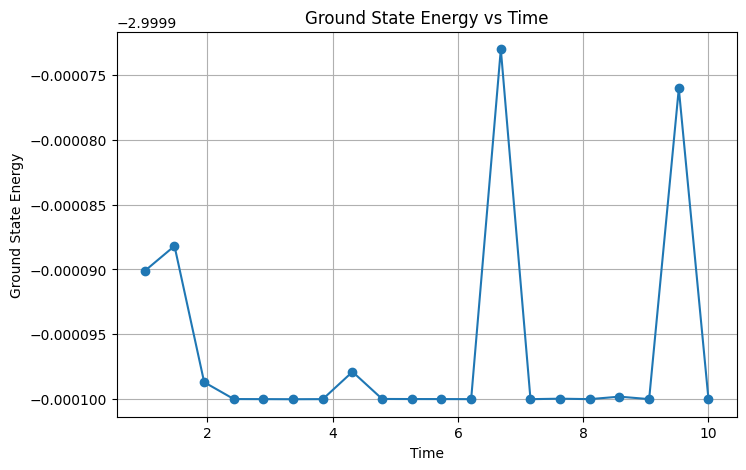

In [ ]:
# Plotting

plt.figure(figsize=(8, 5))
plt.plot(times, energies, marker='o')
plt.xlabel('Time')
plt.ylabel('Ground State Energy')
plt.title('Ground State Energy vs Time')
plt.grid(True)
plt.ticklabel_format(style='plain', axis='y')


In [ ]:
quantum = result.eigenvalue.real

In [ ]:
def cfd_time_averaged(E, J, times):
    classical_energies = []
    for t in times:
        J_t = np.array(J) * np.exp(-0.1 * t)
        E_kin = -np.sum(E)
        E_int = -2 * np.sum(np.triu(J_t, k=1))
        classical_energies.append(E_kin + E_int)
    return np.mean(classical_energies)

classical_avg = cfd_time_averaged(E, J, times)
print("Time-averaged classical:", classical_avg)
print("Quantum ground state:   ", quantum)


Time-averaged classical: -3.95794059463118
Quantum ground state:    -2.9999999933481707


In [ ]:
quantum_avg = np.mean(energies)
print("Time-averaged classical:", classical_avg)
print("Time-averaged quantum:  ", quantum_avg)


Time-averaged classical: -3.95794059463118
Time-averaged quantum:   -2.999999369224011


Classical vs Quantum


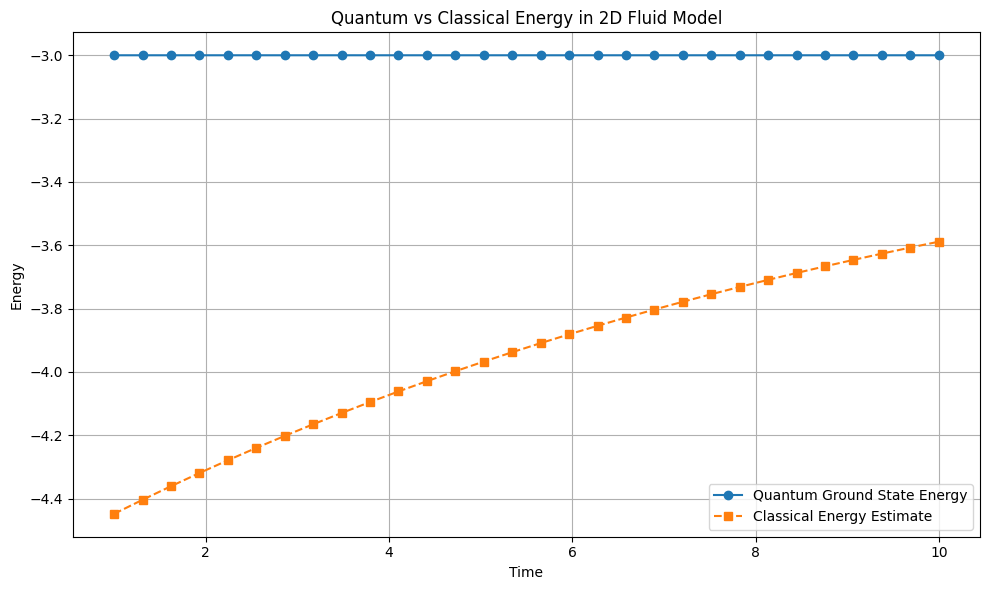

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import PauliSumOp
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import COBYLA

# Parameters
num_qubits = 4
E = [1.0, 1.0, 1.0, 1.0]
J = [
    [0.0, 0.5, 0.3, 0.2],
    [0.5, 0.0, 0.4, 0.1],
    [0.3, 0.4, 0.0, 0.3],
    [0.2, 0.1, 0.3, 0.0]
]

# Apply wall boundary condition
boundary_qubit = 0
E[boundary_qubit] = 0.0
for i in range(num_qubits):
    J[boundary_qubit][i] = 0.0
    J[i][boundary_qubit] = 0.0

# Time-dependent J
def time_dependent_J(t):
    return np.array(J) * np.exp(-0.1 * t)

# Build Hamiltonian
def build_hamiltonian(E, J_t):
    pauli_list = []
    for i in range(num_qubits):
        z_label = "I" * i + "Z" + "I" * (num_qubits - i - 1)
        pauli_list.append((z_label, -E[i]))

        for j in range(i + 1, num_qubits):
            xx_label = "I" * i + "X" + "I" * (j - i - 1) + "X" + "I" * (num_qubits - j - 1)
            yy_label = "I" * i + "Y" + "I" * (j - i - 1) + "Y" + "I" * (num_qubits - j - 1)
            pauli_list.append((xx_label, -J_t[i][j]))
            pauli_list.append((yy_label, -J_t[i][j]))
    return PauliSumOp.from_list(pauli_list)

# Classical CFD estimate
def classical_energy(E, J_t):
    return -np.sum(E) - np.sum(np.triu(J_t, k=1)) * 2

# VQE setup
ansatz = TwoLocal(num_qubits, 'ry', 'cz', reps=1, entanglement='full')
optimizer = COBYLA(maxiter=550)
estimator = Estimator()
vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer)

# Time evolution
times = np.linspace(1, 10, 30)
quantum_energies = []
classical_energies = []

for t in times:
    J_t = time_dependent_J(t)
    hamiltonian_t = build_hamiltonian(E, J_t)

    result = vqe.compute_minimum_eigenvalue(hamiltonian_t)
    quantum_energies.append(result.eigenvalue.real)

    classical = classical_energy(E, J_t)
    classical_energies.append(classical)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(times, quantum_energies, 'o-', label="Quantum Ground State Energy")
plt.plot(times, classical_energies, 's--', label="Classical Energy Estimate")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Quantum vs Classical Energy in 2D Fluid Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
